In [2]:
#import required dependencies here:
import pandas as pd
import datetime

#NOTE: before reading in any .csv files, you need to open the .csv file using a simple text editor and remove the first 
#four lines (starting with '#' symbols) in order to get the csv to load correctly

#read in csv here
AQI_2020_df = pd.read_csv("./2020 Source/waqi-covid19-airqualitydata-2020.csv")

#check output to see if csv loaded into df correctly
AQI_2020_df.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,2020-02-24,BO,Cochabamba,temperature,96,15.0,29.0,21.0,184.40
1,2020-03-06,BO,Cochabamba,temperature,96,14.0,26.0,17.0,136.52
2,2020-06-25,BO,Cochabamba,temperature,96,2.0,26.0,15.0,601.26
3,2020-01-28,BO,Cochabamba,temperature,96,15.0,28.0,20.0,187.35
4,2020-02-07,BO,Cochabamba,temperature,96,14.0,26.0,16.0,180.91


In [2]:
#special case for the 2019 datasets - show how to merge two quarters here
#ignore this cell if you have data from any year besides 2019
#note that there are probably ~2 million rows to in the final table, so the operations might take a few seconds

#read in the different quarters - two are shown here
AQI_Info_Q1_2019 = pd.read_csv("./2019 Source/waqi-covid19-airqualitydata-2019Q1.csv")
AQI_Info_Q2_2019 = pd.read_csv("./2019 Source/waqi-covid19-airqualitydata-2019Q2.csv")

#add the quarters together using pandas' merge operation - outer join
all_quarters_df = AQI_Info_Q1_2019.merge(AQI_Info_Q2_2019, how="outer")

#subsequently merge quarters 3 and 4 into the "all_quarters_df" as shown above, but replacing the "AQI_Info_Q1_2019" df 
#with the "all_quarters_df"

#now check that all the quarters have been joined correctly using an outer join by checking the table length - that is, the 
#total table rows should just be the sum of the rows for each quarter's dataframe, or a merge was performed incorrectly
if(len(all_quarters_df) != (len(AQI_Info_Q1_2019) + len(AQI_Info_Q2_2019))):
    print("Some rows were removed - check your merges!")
else:
    print("The table lengths match, so everything was probably merged correctly!")

The table lengths match, so everything was probably merged correctly!


In [3]:
#group data set by date, and check the date range of the output
#it looks like for 2018 and earlier years the data might only go to the current date (~7/5) because 
#those dates are comparable to the coronavirus shutdown this year
#2019 should have the full range of dates if all quarters are merged correctly
AQI_2020_df.groupby("Date").count()

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2019-12-30,2953,2953,2953,2953,2953,2953,2953,2953
2019-12-31,2939,2939,2939,2939,2939,2939,2939,2939
2020-01-01,3003,3003,3003,3003,3003,3003,3003,3003
2020-01-02,3783,3783,3783,3783,3783,3783,3783,3783
2020-01-03,6909,6909,6909,6909,6909,6909,6909,6909
...,...,...,...,...,...,...,...,...
2020-07-04,6100,6100,6100,6100,6100,6100,6100,6100
2020-07-05,6074,6074,6074,6074,6074,6074,6074,6074
2020-07-06,6058,6058,6058,6058,6058,6058,6058,6058


In [4]:
#now that we have checked out the data date ranges, we should narrow the data down to the desired info
#first select by cities that we are interested in
interesting_city_list = ["Los Angeles", "Houston", "Jacksonville", "Manhattan", "Beijing", "Shanghai", "Wuhan", "New Delhi"]
interesting_cities_AQI = AQI_2020_df.loc[AQI_2020_df["City"].isin(interesting_city_list)]

#this should give some idea about how many records there are for each city we are interested in for the year
#the higher the number the more complete the data!
interesting_cities_AQI["City"].value_counts()

Beijing         2168
Shanghai        2116
Wuhan           2113
Jacksonville    2073
Los Angeles     2018
Manhattan       1807
Houston         1422
New Delhi       1100
Name: City, dtype: int64

In [9]:
#get subsets of o3 and pm2.5 for each city
interesting_cities_o3_2020 = interesting_cities_AQI.loc[interesting_cities_AQI["Specie"] == "o3"]
interesting_cities_pm25_2020 = interesting_cities_AQI.loc[interesting_cities_AQI["Specie"] == "pm25"]

#can check to see if we are missing data for any days for either o3 or pm2.5
print(interesting_cities_o3_2020["City"].value_counts())
print(interesting_cities_pm25_2020["City"].value_counts())

#needed to beef up the AQI conversion table past 500 so that higher AQIs could be converted to concentrations
#used linear regression on the last 50 AQI values (450-500) to extrapolate AQI to concentration conversions for AQI values past 
#500, up to 1000 - but please note that this is an assumption!
print(interesting_cities_pm25_2020["max"].max())

Beijing         192
Wuhan           192
Manhattan       191
Jacksonville    191
Los Angeles     191
Houston         190
Shanghai        149
Name: City, dtype: int64
Shanghai        192
Beijing         192
Wuhan           192
New Delhi       191
Manhattan       191
Jacksonville    191
Los Angeles     191
Houston         190
Name: City, dtype: int64
824.0


In [6]:
#import csv info for conversion table between AQI and pollutant concentrations

pm25_conversion_df = pd.read_csv("../Resources/pm25_conversion.csv")
o3_conversion_df = pd.read_csv("../Resources/o3_conversion.csv")

In [10]:
#conversion from aqi to concentration for pm2.5
#variance omitted because that calculation is not directly proportional to AQI and not that relevant for our project

#function AQI_to_Conc takes an o3 or an pm25 dataframe as an argument
#returns a new dataframe with the min, max, and median values converted to measures with units
#also drops the variance column for the new dataframe returned
def AQI_to_Conc(df):
    #setup dictionary to choose how to convert input data
    types = {"o3":o3_conversion_df, "pm25":pm25_conversion_df}
    
    #picks conversion df dynamically
    pollutant = df["Specie"].iloc[0]
    conversion_df = types[pollutant]
    
    #copy input dataframe -> will be changed by function
    updated_df = df.copy()
    
    #get the units for the concentration measurements
    units = conversion_df.columns[0].replace(pollutant, "")
    
    #add the new columns
    update_columns = ["min", "max", "median"]
    for col in update_columns:
        #note that we need to round the AQI to get an integer for row lookup
        updated_df[col + units] = updated_df[col].apply(lambda x: conversion_df[pollutant + units][round(x)])
    
    #drop the old columns (and "variance")
    updated_df = updated_df.drop(axis=1, columns=(update_columns+["variance"]))

    return updated_df
    
#get new dataframes for the concentrations of the pollutants using the above function
#only takes the dataframe for one pollutant as an argument
interesting_cities_pm25_2020_conc = AQI_to_Conc(interesting_cities_pm25_2020)
interesting_cities_o3_2020_conc = AQI_to_Conc(interesting_cities_o3_2020)

print(interesting_cities_pm25_2020_conc.head())
interesting_cities_o3_2020_conc.head()


              Date Country     City Specie  count  min (ug/m3)  max (ug/m3)  \
214021  2020-01-26      US  Houston   pm25     96          0.9         23.5   
214022  2020-02-14      US  Houston   pm25     72          1.2         17.8   
214023  2020-05-09      US  Houston   pm25    120          0.9         18.2   
214024  2020-05-14      US  Houston   pm25    120          1.6         22.5   
214025  2020-05-23      US  Houston   pm25    118          5.0         15.9   

        median (ug/m3)  
214021             6.4  
214022             4.5  
214023             5.2  
214024             7.9  
214025            10.0  


,Date,Country,City,Specie,count,min (ppb),max (ppb),median (ppb)
213142,2020-06-03,US,Houston,o3,116,1.0,46.0,17.0
213143,2020-06-28,US,Houston,o3,113,2.0,23.0,11.0
213144,2020-01-16,US,Houston,o3,112,1.0,22.0,10.0
213145,2020-03-01,US,Houston,o3,5,29.0,34.0,32.0
213146,2020-03-20,US,Houston,o3,112,2.0,28.0,15.0


In [11]:
#output the pm25 concentration data for our cities for the year 2018
interesting_cities_pm25_2020_conc.to_csv("./2020 Cleaned/our_cities_pm25_2020.csv", index=False)

#output the o3 concentration data for our cities for the year 2018
interesting_cities_o3_2020_conc.to_csv("./2020 Cleaned/our_cities_o3_2020.csv", index=False)

## Stopping Point

After you have generated the dataframes that contain the concentrations for each pollutant for the cities we are looking at, and exported the CSVs for those two pollutants for those cities for your year, you are done with this first part of the project. We will need to combine the data from the first 3 years into a larger, aggregate dataframe. From this dataframe we can break down the data by month and then calculate values for each year or all three years combined.

In [61]:
#select by for a certain city, in this case we are doing Wuhan
wuhan_2018_pm25 = interesting_cities_pm25_2018_conc.loc[interesting_cities_pm25_2018_conc["City"] == "Wuhan"]
wuhan_2018_pm25.head()

,Date,Country,City,Specie,count,min (ug/m3),max (ug/m3),median (ug/m3)
227431,2018-01-29,CN,Wuhan,pm25,301,37.9,119.4,72.9
227432,2018-02-03,CN,Wuhan,pm25,400,11.0,52.1,25.8
227433,2018-04-07,CN,Wuhan,pm25,406,5.0,92.2,23.9
227434,2018-05-08,CN,Wuhan,pm25,402,4.0,46.8,21.1
227435,2018-05-09,CN,Wuhan,pm25,368,10.0,70.9,32.0


In [62]:
#convert "Date" column values to datetime objects
wuhan_2018_pm25["Date"] = pd.to_datetime(wuhan_2018_pm25["Date"])

#re-index by date
wuhan_2018_pm25 = wuhan_2018_pm25.set_index("Date")
wuhan_2018_pm25

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,City,Specie,count,min (ug/m3),max (ug/m3),median (ug/m3)
Date,,,,,,,
2018-01-29,CN,Wuhan,pm25,301,37.9,119.4,72.9
2018-02-03,CN,Wuhan,pm25,400,11.0,52.1,25.8
2018-04-07,CN,Wuhan,pm25,406,5.0,92.2,23.9
2018-05-08,CN,Wuhan,pm25,402,4.0,46.8,21.1
2018-05-09,CN,Wuhan,pm25,368,10.0,70.9,32.0
...,...,...,...,...,...,...,...
2018-02-08,CN,Wuhan,pm25,406,41.9,151.5,78.7
2018-06-26,CN,Wuhan,pm25,386,2.1,44.8,14.9
2018-01-25,CN,Wuhan,pm25,391,14.0,54.9,32.0


In [63]:
#example of getting data for a month
wuhan_jan_2018_pm25 = wuhan_2018_pm25.loc[wuhan_2018_pm25.index.month == 1]
wuhan_jan_2018_pm25

,Country,City,Specie,count,min (ug/m3),max (ug/m3),median (ug/m3)
Date,,,,,,,
2018-01-29,CN,Wuhan,pm25,301,37.9,119.4,72.9
2018-01-19,CN,Wuhan,pm25,405,78.7,217.1,140.7
2018-01-23,CN,Wuhan,pm25,400,63.2,159.5,103.9
2018-01-26,CN,Wuhan,pm25,369,15.9,67.1,34.9
2018-01-20,CN,Wuhan,pm25,306,46.8,230.2,151.5
2018-01-30,CN,Wuhan,pm25,403,22.0,165.6,67.1
2018-01-18,CN,Wuhan,pm25,396,2.1,214.0,127.1
2018-01-28,CN,Wuhan,pm25,406,29.2,82.6,52.1
2018-01-16,CN,Wuhan,pm25,297,52.1,183.8,113.6


In [64]:
#can get summary stats for a month as follows

#can look at averages of medians, median of medians, average maximum for the month, maximum values for each month overall, etc.
#can also write a function later to do this for each month and output the relevant statistics to a dataframe
wuhan_jan_2018_pm25.describe()

,count,min (ug/m3),max (ug/m3),median (ug/m3)
count,16.000000,16.000000,16.000000,16.000000
mean,377.250000,32.906250,147.706250,83.881250
std,39.092199,19.508715,59.858906,38.776801
min,297.000000,2.100000,54.900000,32.000000
25%,375.750000,20.700000,104.350000,50.775000
50%,393.500000,29.200000,154.950000,73.850000
75%,402.250000,40.125000,194.350000,115.525000
max,406.000000,78.700000,230.200000,151.500000


,Country,City,Specie,count,min (ug/m3),max (ug/m3),median (ug/m3)
Date,,,,,,,
2018-01-16,CN,Wuhan,pm25,297,52.1,183.8,113.6
2018-01-17,CN,Wuhan,pm25,400,34.9,187.8,98.1
2018-01-18,CN,Wuhan,pm25,396,2.1,214.0,127.1
2018-01-19,CN,Wuhan,pm25,405,78.7,217.1,140.7
2018-01-20,CN,Wuhan,pm25,306,46.8,230.2,151.5
...,...,...,...,...,...,...,...
2018-06-27,CN,Wuhan,pm25,368,2.1,52.1,16.8
2018-06-28,CN,Wuhan,pm25,383,3.1,57.4,17.8
2018-06-29,CN,Wuhan,pm25,398,5.0,67.1,29.2


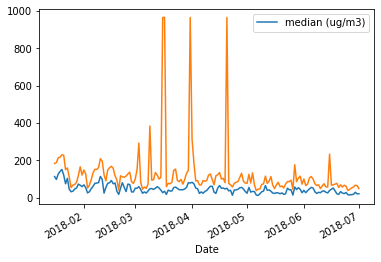

In [74]:
#example line plot for wuhan for overall time period of 2018 for pm2.5

#first plot median line graph
example_plot = wuhan_2018_pm25.plot(kind="line", y="median (ug/m3)")

#sort the values by date
wuhan_2018_pm25 = wuhan_2018_pm25.sort_values(by="Date")

#then plot the max line graph on the same plot
example_plot.plot(wuhan_2018_pm25.index, wuhan_2018_pm25["max (ug/m3)"])
wuhan_2018_pm25

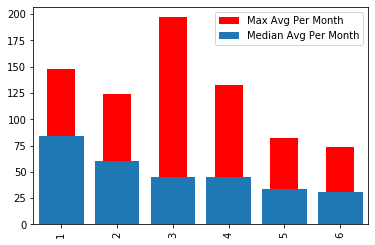

In [98]:
#example bar graph
averages_per_month = []
max_averages_per_month = []
months = []
for m in range(1, 7):
    months.append(m)
    curr_month_wuhan = wuhan_2018_pm25.loc[wuhan_2018_pm25.index.month == m]
    averages_per_month.append(curr_month_wuhan["median (ug/m3)"].mean())
    max_averages_per_month.append(curr_month_wuhan["max (ug/m3)"].mean())
    
bar_chart_df = pd.DataFrame({"Median Average per Month Wuhan 2018":averages_per_month, 
                             "Max Avg Per Month":max_averages_per_month}, index=months)
bar_axes = bar_chart_df.plot(kind="bar", y="Max Avg Per Month", color="r")
bar_axes.bar([a-1 for a in months], bar_chart_df["Median Average per Month Wuhan 2018"], label="Median Avg Per Month")
bar_axes.legend(loc="best")

I wanted to do the shutdown times vs. previous years by month on a chart like the one above for some measure of center to get the percentage pollution decrease